In [19]:
import chardet
import numpy as np
import pandas as pd
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
import string
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# **Step 01: Detect the file's encoding**

In [20]:
file_path = '/content/urdu-news-dataset-1M.csv'

with open(file_path, 'rb') as file:
    result = chardet.detect(file.read())

file_encoding = result['encoding']

print(f"Detected file encoding: {file_encoding}")

Detected file encoding: UTF-8-SIG


# **Step 02: Opening the file and loading the dataset**


In [21]:
with open(file_path, 'r', encoding=file_encoding, errors='replace') as file:
    data = pd.read_csv(file)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111861 entries, 0 to 111860
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Index        111861 non-null  int64  
 1   Headline     111861 non-null  object 
 2   News Text    111861 non-null  object 
 3   Category     111860 non-null  object 
 4   Date         111860 non-null  object 
 5   URL          111860 non-null  object 
 6   Source       111860 non-null  object 
 7   News length  111860 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 6.8+ MB


# **Step 03: Data Analysis**

In [22]:
data.head()

,Index,Headline,News Text,Category,Date,URL,Source,News length
0,0,عالمی بینک عسکریت پسندی سے متاثرہ خاندانوں کی ...,اسلام باد عالمی بینک خیبرپختونخوا کے قبائلی اض...,Business & Economics,2020-12-06,https://www.dawnnews.tv/news/1148499/,Dawn News,1854.0
1,1,مالی سال 2020 ریٹرن فائل کرنے والوں کی تعداد م...,اسلام باد فیڈرل بورڈ ریونیو ایف بی نے دسمبر کی...,Business & Economics,2020-12-06,https://www.dawnnews.tv/news/1148498/,Dawn News,2016.0
2,2,جاپان کو سندھ کے خصوصی اقتصادی زون میں سرمایہ ...,اسلام باد بورڈ انویسٹمنٹ بی او ئی کے چیئرمین ع...,Business & Economics,2020-12-05,https://www.dawnnews.tv/news/1148433/,Dawn News,2195.0
3,3,برامدات 767 فیصد بڑھ کر ارب 16 کروڑ ڈالر سے زائد,اسلام اباد پاکستان میں ماہ نومبر میں مسلسل تیس...,Business & Economics,2020-12-05,https://www.dawnnews.tv/news/1148430/,Dawn News,2349.0
4,4,کے الیکٹرک کو اضافی بجلی گیس کی فراہمی کے قانو...,اسلام باد نیشنل ٹرانسمیشن اینڈ ڈسپیچ کمپنی این...,Business & Economics,2020-12-05,https://www.dawnnews.tv/news/1148421/,Dawn News,2655.0


# **Step 04: Let's check unique categories in our dataset**


In [23]:
print("Unique categories:", data['Category'].unique())
print("\nNumber of articles per category:\n", data['Category'].value_counts())

Unique categories: ['Business & Economics' 'Entertainment' 'Science & Technology' 'Sports'
 nan]

Number of articles per category:
 Category
Sports                  44829
Entertainment           34901
Business & Economics    24131
Science & Technology     7999
Name: count, dtype: int64


# **Step 05: Exploratory Data Analysis**

## **Category Distribution (Pie Chart)**

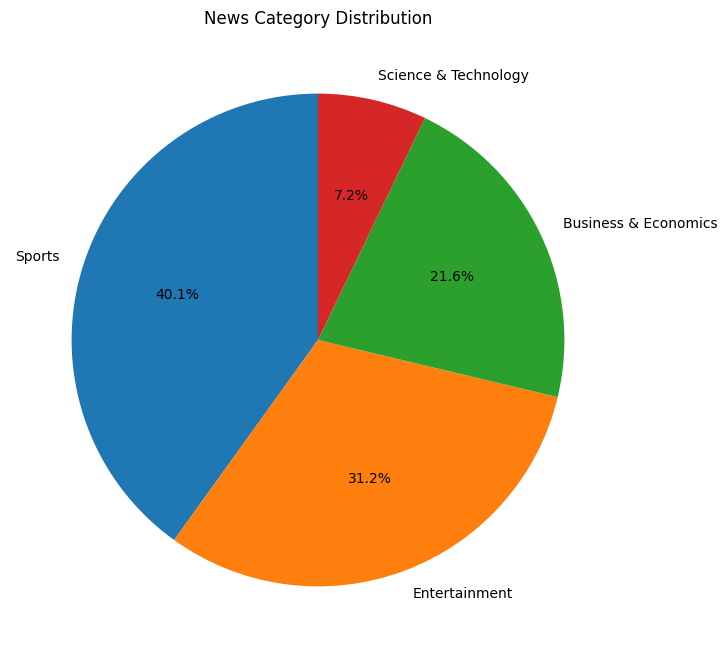

In [24]:
plt.figure(figsize=(8, 8))
category_counts = data['Category'].value_counts()
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('News Category Distribution')
plt.show()


## **News Length Distribution by Category (Box Plot)**

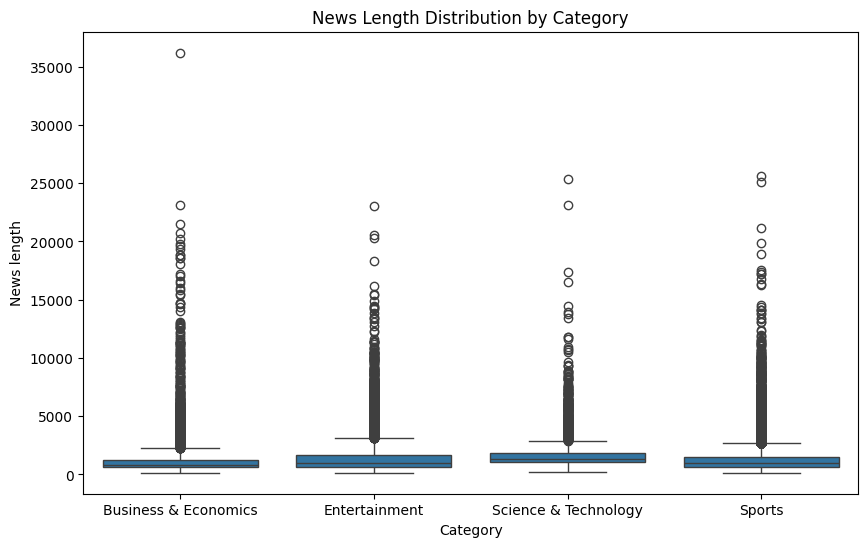

In [25]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Category', y='News length', data=data)  # Using 'Category' and 'News length' as the column names
plt.title('News Length Distribution by Category')
plt.show()

## **Plotting the top words for each category**

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
<ipython-input-26-f9d85d6d7d59>:23: UserWarning: Glyph 1746 (\N{ARABIC LETTER YEH BARREE}) missing from current font.
  plt.tight_layout()
<ipython-input-26-f9d85d6d7d59>:23: UserWarning: Matplotlib currently does not support Arabic natively.
  plt.tight_layout()
<ipython-input-26-f9d85d6d7d59>:23: UserWarning: Glyph 1729 (\N{ARABIC LETTER HEH GOAL}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1746 (\N{ARABIC LETTER YEH BARREE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Arabic natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1729 (\N{ARABIC 

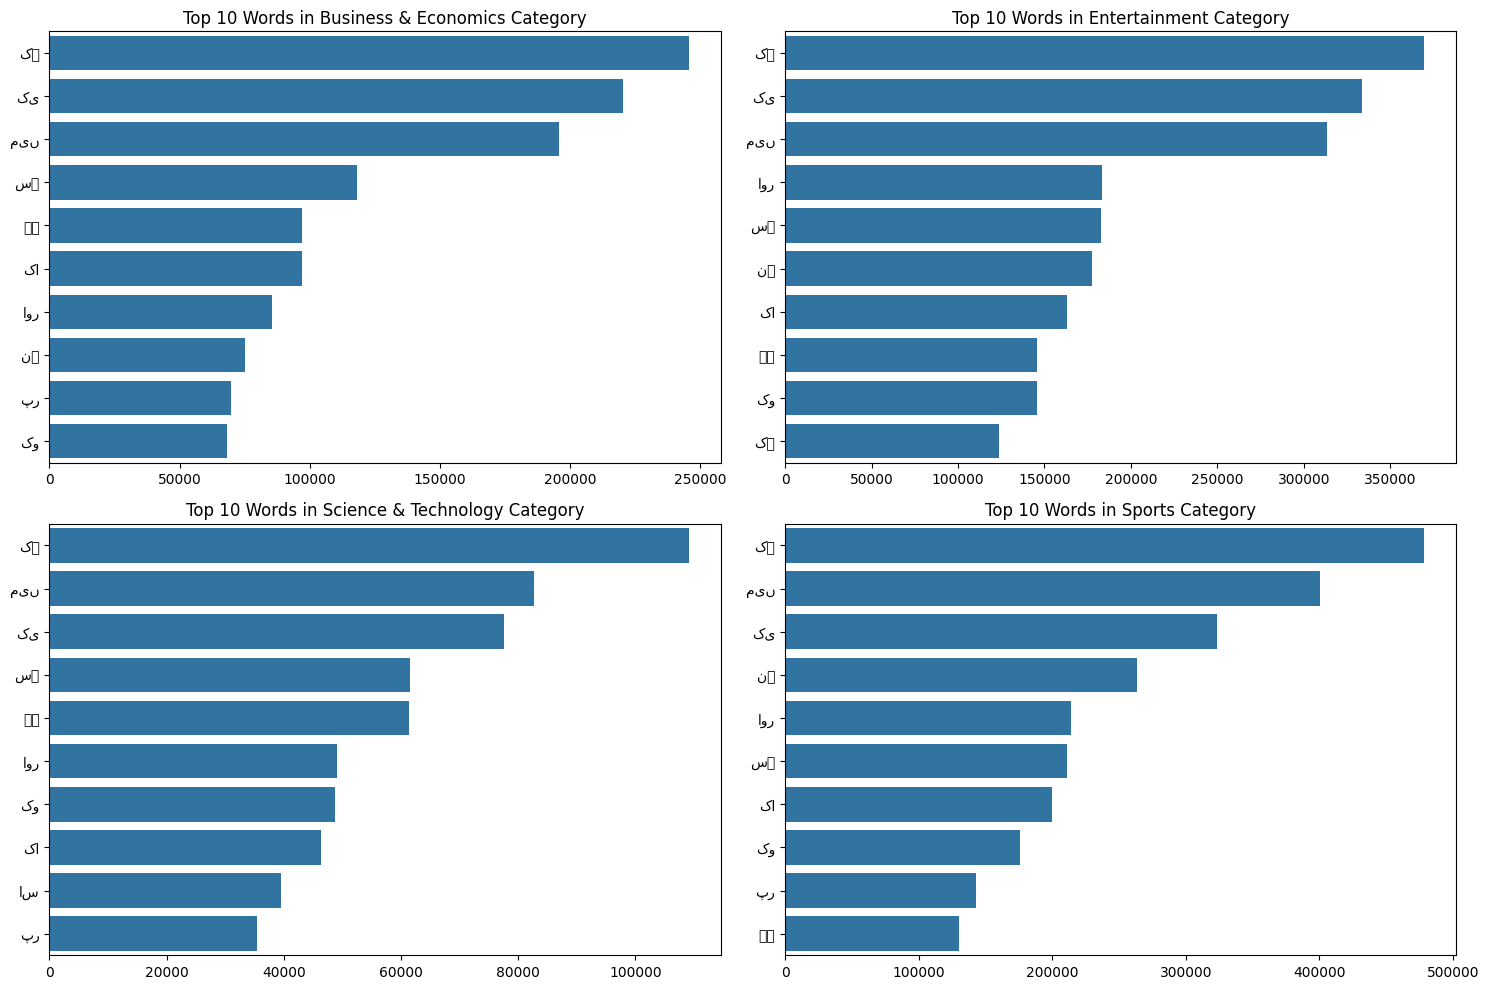

In [26]:
nltk.download('punkt_tab')
category_words = {}
for category, group in data.groupby('Category'):
    # Concatenate all text within the category
    text = ' '.join(group['News Text'].dropna().astype(str))
    # Tokenize and remove punctuation
    words = word_tokenize(text)
    words = [word.lower() for word in words if word.isalpha()]
    # Count word frequencies
    word_freq = Counter(words)
    category_words[category] = word_freq


fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for idx, (category, word_freq) in enumerate(category_words.items()):
    ax = axes[idx // 2, idx % 2]
    sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
    top_words = sorted_words[:10]
    words, counts = zip(*top_words)
    sns.barplot(x=list(counts), y=list(words), ax=ax)
    ax.set_title(f'Top 10 Words in {category} Category')

plt.tight_layout()
plt.show()

# **Step 06: Basic text preprocessing**

In [27]:
def preprocess_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^\w\s]', '', str(text))
    text = re.sub(r'\d+', '', text)
    # Remove extra spaces
    text = ' '.join(text.split())
    return text

### **Apply preprocessing to News Text**


In [28]:
data['cleaned_text'] = data['News Text'].apply(preprocess_text)

# **Step 07: Encode the categories**

In [29]:
label_encoder = LabelEncoder()
data['category_encoded'] = label_encoder.fit_transform(data['Category'])

# **Step 08: Split the data into features and target**


In [30]:
X = data['cleaned_text']
y = data['category_encoded']

### **keep stratification but remove rare categories**

In [31]:
category_counts = data['Category'].value_counts()
valid_categories = category_counts[category_counts >= 2].index
mask = data['Category'].isin(valid_categories)

# **Step 09: Again split the data into features and target**

In [32]:
X = data[mask]['cleaned_text']
y = data[mask]['category_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nTraining set size:", len(X_train))
print("Test set size:", len(X_test))


Training set size: 89488
Test set size: 22372


# **Step 10: Create TF-IDF features**


In [33]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# **Step 11: Train a Naive Bayes classifier**

In [34]:
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

MultinomialNB()

# **Step 12: Make predictions**

In [35]:
y_pred = model.predict(X_test_tfidf)

# **Step 13: Evaluate the model**

In [36]:
# Get unique classes from both test and predicted data
unique_classes = np.unique(np.concatenate([y_test, y_pred]))
class_names = label_encoder.inverse_transform(unique_classes)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))


Classification Report:
                      precision    recall  f1-score   support

Business & Economics       0.95      0.97      0.96      4826
       Entertainment       0.94      0.94      0.94      6980
Science & Technology       0.83      0.90      0.87      1600
              Sports       0.99      0.97      0.98      8966

            accuracy                           0.96     22372
           macro avg       0.93      0.95      0.94     22372
        weighted avg       0.96      0.96      0.96     22372



### **Additional information about the classes**

In [37]:
print("\nNumber of classes in test set:", len(np.unique(y_test)))
print("Number of classes in predictions:", len(np.unique(y_pred)))
print("\nClass distribution in test set:")
for class_id in np.unique(y_test):
    class_name = label_encoder.inverse_transform([class_id])[0]
    count = sum(y_test == class_id)
    print(f"{class_name}: {count}")


Number of classes in test set: 4
Number of classes in predictions: 4

Class distribution in test set:
Business & Economics: 4826
Entertainment: 6980
Science & Technology: 1600
Sports: 8966


# **Step 14: Create confusion matrix**

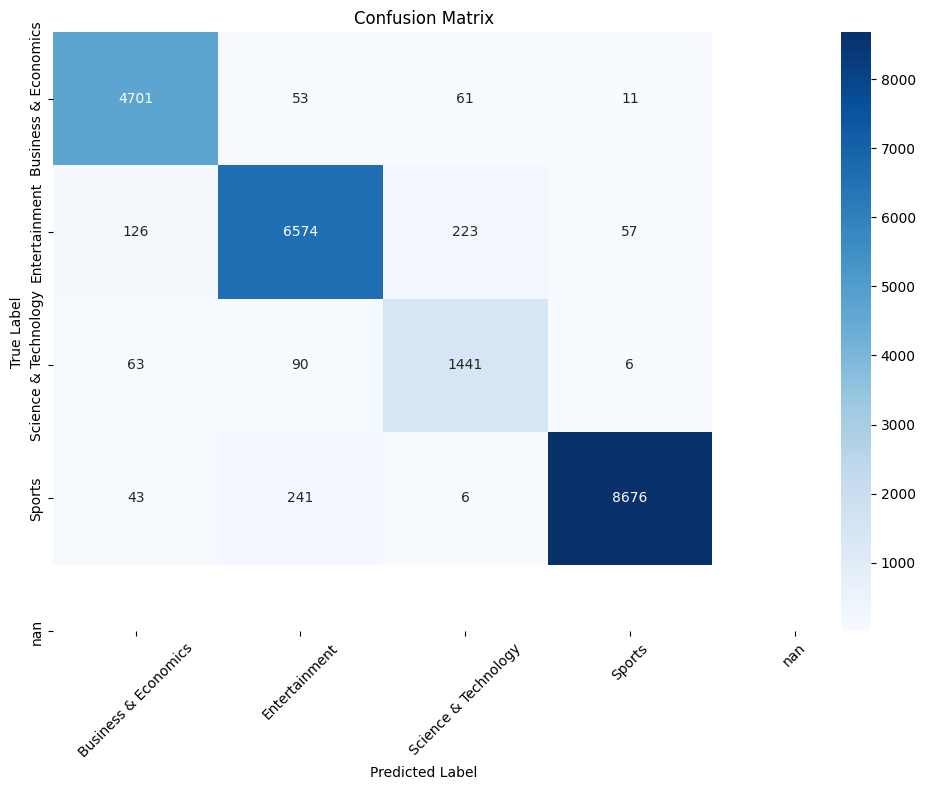

In [38]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **Test Cases on unseen data**

In [39]:
def predict_new_text(text):
    # Preprocess the text
    cleaned = preprocess_text(text)
    # Transform using tf-idf
    text_tfidf = tfidf.transform([cleaned])
    # Predict
    prediction = model.predict(text_tfidf)
    # Get the predicted category name
    predicted_category = label_encoder.inverse_transform(prediction)[0]
    return predicted_category

In [40]:
# Example usage 01:
sample_text = "بابر اعظم کو اس کا حق دیجیے اور فیب فائیو میں اسے شامل کیجیے"  # Replace with actual Urdu news text
print("\nPredicted category:", predict_new_text(sample_text))


def predict_probabilities(text):
    cleaned = preprocess_text(text)
    text_tfidf = tfidf.transform([cleaned])
    probabilities = model.predict_proba(text_tfidf)[0]
    # Get categories and their probabilities
    categories = label_encoder.classes_
    prob_dict = dict(zip(categories, probabilities))
    # Sort by probability
    return dict(sorted(prob_dict.items(), key=lambda x: x[1], reverse=True))

# Example usage:
print("\nPrediction probabilities:", predict_probabilities(sample_text))


Predicted category: Sports

Prediction probabilities: {'Sports': 0.8228966537979098, 'Entertainment': 0.1140197798362497, 'Business & Economics': 0.03376850453967317, 'Science & Technology': 0.029315061826165657}


In [41]:
# Example usage 02:
sample_text = "سوشل میڈیا انفلوئنسرز کی جانب سے تجارتی ایپس کی تشہیر قانونی عمل ہے؟"  # Replace with actual Urdu news text
print("\nPredicted category:", predict_new_text(sample_text))


def predict_probabilities(text):
    cleaned = preprocess_text(text)
    text_tfidf = tfidf.transform([cleaned])
    probabilities = model.predict_proba(text_tfidf)[0]
    # Get categories and their probabilities
    categories = label_encoder.classes_
    prob_dict = dict(zip(categories, probabilities))
    # Sort by probability
    return dict(sorted(prob_dict.items(), key=lambda x: x[1], reverse=True))

# Example usage:
print("\nPrediction probabilities:", predict_probabilities(sample_text))


Predicted category: Science & Technology

Prediction probabilities: {'Science & Technology': 0.43790835338943473, 'Entertainment': 0.37553747414899136, 'Business & Economics': 0.17089890915941777, 'Sports': 0.01565526330215722}


In [42]:
# Example usage 03:
sample_text = "’جموں کی دھڑکن‘ سمجھی جانے والی انسٹاگرام سٹار سمرن سنگھ کمرے میں مردہ پائی گئیں"  # Replace with actual Urdu news text
print("\nPredicted category:", predict_new_text(sample_text))


def predict_probabilities(text):
    cleaned = preprocess_text(text)
    text_tfidf = tfidf.transform([cleaned])
    probabilities = model.predict_proba(text_tfidf)[0]
    # Get categories and their probabilities
    categories = label_encoder.classes_
    prob_dict = dict(zip(categories, probabilities))
    # Sort by probability
    return dict(sorted(prob_dict.items(), key=lambda x: x[1], reverse=True))

# Example usage:
print("\nPrediction probabilities:", predict_probabilities(sample_text))


Predicted category: Entertainment

Prediction probabilities: {'Entertainment': 0.8946868711146756, 'Sports': 0.08436536648776514, 'Science & Technology': 0.017954521953872687, 'Business & Economics': 0.00299324044368761}


In [43]:
# Example usage 04:
sample_text = "گرل فرینڈ سے بریک اپ، انڈیا میں نوجوان کی مچھر بھگانے والی دوا سے خودکشی کی کوشش"  # Replace with actual Urdu news text
print("\nPredicted category:", predict_new_text(sample_text))


def predict_probabilities(text):
    cleaned = preprocess_text(text)
    text_tfidf = tfidf.transform([cleaned])
    probabilities = model.predict_proba(text_tfidf)[0]
    # Get categories and their probabilities
    categories = label_encoder.classes_
    prob_dict = dict(zip(categories, probabilities))
    # Sort by probability
    return dict(sorted(prob_dict.items(), key=lambda x: x[1], reverse=True))

# Example usage:
print("\nPrediction probabilities:", predict_probabilities(sample_text))


Predicted category: Entertainment

Prediction probabilities: {'Entertainment': 0.940554494765136, 'Sports': 0.04062564310030906, 'Science & Technology': 0.017156125389037043, 'Business & Economics': 0.0016637367455185007}


In [44]:
# Example usage 05:
sample_text = "سعودی فارورڈ صالح الشہری انجری کے باعث گلف کپ سے باہر"  # Replace with actual Urdu news text
print("\nPredicted category:", predict_new_text(sample_text))


def predict_probabilities(text):
    cleaned = preprocess_text(text)
    text_tfidf = tfidf.transform([cleaned])
    probabilities = model.predict_proba(text_tfidf)[0]
    # Get categories and their probabilities
    categories = label_encoder.classes_
    prob_dict = dict(zip(categories, probabilities))
    # Sort by probability
    return dict(sorted(prob_dict.items(), key=lambda x: x[1], reverse=True))

# Example usage:
print("\nPrediction probabilities:", predict_probabilities(sample_text))


Predicted category: Sports

Prediction probabilities: {'Sports': 0.9434668115479063, 'Entertainment': 0.030856697711456067, 'Business & Economics': 0.018578589473195163, 'Science & Technology': 0.007097901267443955}


In [45]:
# Example usage 06:
sample_text = "ریاستی ملکیتی اداروں نے 6 ماہ میں 147 ارب روپے کا نقصان کیا، رپورٹ میں انکشاف"  # Replace with actual Urdu news text
print("\nPredicted category:", predict_new_text(sample_text))


def predict_probabilities(text):
    cleaned = preprocess_text(text)
    text_tfidf = tfidf.transform([cleaned])
    probabilities = model.predict_proba(text_tfidf)[0]
    # Get categories and their probabilities
    categories = label_encoder.classes_
    prob_dict = dict(zip(categories, probabilities))
    # Sort by probability
    return dict(sorted(prob_dict.items(), key=lambda x: x[1], reverse=True))

# Example usage:
print("\nPrediction probabilities:", predict_probabilities(sample_text))


Predicted category: Business & Economics

Prediction probabilities: {'Business & Economics': 0.8974748246038265, 'Entertainment': 0.04419611184019111, 'Science & Technology': 0.04004691114146338, 'Sports': 0.01828215241451746}


In [46]:
# Example usage 07:
sample_text = "دنیا کا سب سے بڑا انجن جو یومیہ 250 ٹن ایندھن استعمال کرتا ہے"  # Replace with actual Urdu news text
print("\nPredicted category:", predict_new_text(sample_text))


def predict_probabilities(text):
    cleaned = preprocess_text(text)
    text_tfidf = tfidf.transform([cleaned])
    probabilities = model.predict_proba(text_tfidf)[0]
    # Get categories and their probabilities
    categories = label_encoder.classes_
    prob_dict = dict(zip(categories, probabilities))
    # Sort by probability
    return dict(sorted(prob_dict.items(), key=lambda x: x[1], reverse=True))

# Example usage:
print("\nPrediction probabilities:", predict_probabilities(sample_text))


Predicted category: Business & Economics

Prediction probabilities: {'Business & Economics': 0.7123159477986609, 'Science & Technology': 0.2590737993185356, 'Entertainment': 0.025760590791863856, 'Sports': 0.002849662090937982}


In [47]:
# Example usage 08:
sample_text = "رواں مالی سال ترسیلات زر میں اضافہ ریکارڈ، 5 ماہ میں ترسیلات زر 14.77 ارب ڈالر رہیں: وزارت خزانہ"  # Replace with actual Urdu news text
print("\nPredicted category:", predict_new_text(sample_text))


def predict_probabilities(text):
    cleaned = preprocess_text(text)
    text_tfidf = tfidf.transform([cleaned])
    probabilities = model.predict_proba(text_tfidf)[0]
    # Get categories and their probabilities
    categories = label_encoder.classes_
    prob_dict = dict(zip(categories, probabilities))
    # Sort by probability
    return dict(sorted(prob_dict.items(), key=lambda x: x[1], reverse=True))

# Example usage:
print("\nPrediction probabilities:", predict_probabilities(sample_text))


Predicted category: Business & Economics

Prediction probabilities: {'Business & Economics': 0.9990258049549948, 'Entertainment': 0.0006352539125006156, 'Science & Technology': 0.0002253353867299533, 'Sports': 0.00011360574577291435}


In [48]:
# Example usage 09:
sample_text = "آسٹریلوی ٹینس سٹار میکس پرسل ڈوپنگ کے الزام میں معطل"  # Replace with actual Urdu news text
print("\nPredicted category:", predict_new_text(sample_text))


def predict_probabilities(text):
    cleaned = preprocess_text(text)
    text_tfidf = tfidf.transform([cleaned])
    probabilities = model.predict_proba(text_tfidf)[0]
    # Get categories and their probabilities
    categories = label_encoder.classes_
    prob_dict = dict(zip(categories, probabilities))
    # Sort by probability
    return dict(sorted(prob_dict.items(), key=lambda x: x[1], reverse=True))

# Example usage:
print("\nPrediction probabilities:", predict_probabilities(sample_text))


Predicted category: Sports

Prediction probabilities: {'Sports': 0.9388859375687331, 'Entertainment': 0.0491972968704925, 'Science & Technology': 0.008911687133955622, 'Business & Economics': 0.0030050784268197584}
